In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle

from astropy.io import fits
science_list = np.genfromtxt('/home/alcadis/Desktop/lab2/group13_WASP-12_20230113/science/science.list', dtype=str)
science_test_list = science_list[:10]
science_frame_name = '/home/alcadis/Desktop/lab2/group13_WASP-12_20230113/correct/' + science_test_list[-1][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

In [2]:
x_target_refined = 267.80
y_target_refined = 63.08

In [3]:
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

vmin:  692.3    vmax: 94792.0


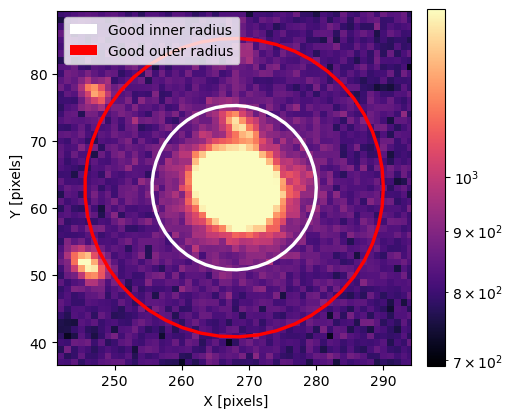

In [33]:
inner_radius = 12
outer_radius = 22

def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)


from matplotlib import colors 

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 2*vmin

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-outer_radius*1.2, x_target_refined+outer_radius*1.2)
plt.ylim(y_target_refined-outer_radius*1.2, y_target_refined+outer_radius*1.2)

make_circle_around_star(x_target_refined, y_target_refined, inner_radius, label='Good inner radius')
make_circle_around_star(x_target_refined, y_target_refined, outer_radius, color='red', label='Good outer radius')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()

In [34]:
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)
annulus_selection = (target_distance > inner_radius) & (target_distance < outer_radius)

sky_flux_average = np.sum(science_corrected[annulus_selection]) / np.sum(annulus_selection)
sky_flux_median = np.median(science_corrected[annulus_selection])
print("Number of pixels in the annulus: {0:7.0f}" .format(np.sum(annulus_selection))) #1000 pixels minimum requirement
print("Average sky flux per pixel: {0:7.1f}" .format(sky_flux_average))
print("Median sky flux per pixel: {0:7.1f}" .format(sky_flux_median))

#we need the errors! calculate it
#the number of pixels must be high but the difference between median and average must be within the error

Number of pixels in the annulus:    1066
Average sky flux per pixel:   840.7
Median sky flux per pixel:   838.6


In [32]:
# subtract the sky from the image

science_sky_corrected = science_corrected - sky_flux_median #only for the target star
#science_sky_corrected_err = to be computed!!

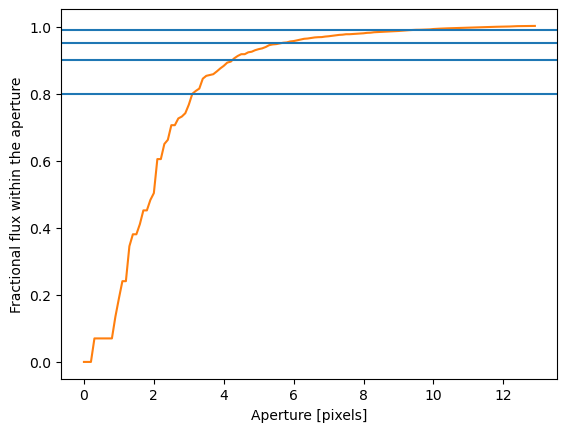

In [48]:
inner_selection = (target_distance < inner_radius)
total_flux = np.sum(science_sky_corrected[inner_selection])
radius_array = np.arange(0, inner_radius + 1., 0.1)
flux_vs_radius = np.zeros_like(radius_array)

for ii, aperture_radius in enumerate(radius_array):
    aperture_selection = (target_distance < aperture_radius)
    flux_vs_radius[ii] = np.sum(science_sky_corrected[aperture_selection]) / total_flux
    #print(ii, aperture_radius, flux_vs_radius[ii])

plt.figure()
plt.plot(radius_array, flux_vs_radius, c='C1')
plt.axhline(0.80)
plt.axhline(0.90)
plt.axhline(0.95)
plt.axhline(0.99)
plt.xlabel("Aperture [pixels]")
plt.ylabel("Fractional flux within the aperture")
plt.show()

In [43]:
aperture_01 = 3.0
aperture_02 = 4.0
aperture_03 = 6.0

aperture_selection = (target_distance < aperture_01)
flux_vs_radius_01 = np.sum(science_sky_corrected[aperture_selection]) / total_flux

aperture_selection = (target_distance < aperture_02)
flux_vs_radius_02 = np.sum(science_sky_corrected[aperture_selection]) / total_flux

aperture_selection = (target_distance < aperture_03)
flux_vs_radius_03 = np.sum(science_sky_corrected[aperture_selection]) / total_flux

print('Frictional flux at aperture {0:2.1f} pixel: {1:3.3f} '. format(aperture_01, flux_vs_radius_01))
print('Frictional flux at aperture {0:2.1f} pixel: {1:3.3f} '. format(aperture_02, flux_vs_radius_02))
print('Frictional flux at aperture {0:2.1f} pixel: {1:3.3f} '. format(aperture_03, flux_vs_radius_03))

Frictional flux at aperture 3.0 pixel: 0.767 
Frictional flux at aperture 4.0 pixel: 0.883 
Frictional flux at aperture 6.0 pixel: 0.957 


In [49]:
aperture_selection = (target_distance < aperture_01)
aperture_photometry_01 = np.sum(science_sky_corrected[aperture_selection])

#photon noise, bias noise readout noise already deleated

# error associated to sky background estimate (median -> average)
# error associated to the sky corrected pixel (it was difference ... )
# error associated to the aperture photometry (error)